# Multi-class Classification

In multi-class classification, we are given input $x \in \mathcal{X}$ and the goal is to determine to which of the $k$ classes $\mathcal{Y} = \{c_1, ..., c_k\}$ it belongs.

As seen in the lectures, we can re-use the binary classifiers to do multi-class classification using the techniques of:
- One-vs-Rest
- All pairs decomposition

In this exercise, we will implement these techniques from scratch using the pendigits dataset.

## Dataset

The [pendigits data](https://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits) is a collection of handwritten digits, each described in terms of 16 (numerical) attributes.

The file "pendigits.tra" contains 7494 training examples and "pendigits.tes" contains 3498 testing examples. There are 16 input attributes which are integers $x\in \{0, ..., 100\}$ and 1 class attribute which is the class code $c\in \{0, ..., 9\}$.

## Exercise (A) One-vs-Rest Decomposition

Train a 10-class classifier on this data using **one-vs-rest decomposition** with (binary) [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) as a base learner.

Randomly select half of the data for training and use the other half for estimating the generalization **accuracy** of your classifier. Repeat this process 10 times and report the mean and standard deviation of your accuracy estimates. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin

def read(filename: str):
  """
  Reads file containing comma separated features with class label as the last item and returns a tuple of (features, labels) lists.

  Parameters
  ----------
  filename: str
      Filename to read the features and labels from.

  Returns
  -------
  (X, y) : tuple[list, list]
      A tuple of all features (X) and class (y) list.
  """
  X = []
  y = []
  with open(filename) as file:
    for line in file:
      items = [int(data) for data in line.split(',')]
      X.append(items[:-1])
      y.append(items[-1])
  return (X, y)

def train_test_split(X: list, y: list):
  """
  Split the training and test examples for experiment.

  Parameters
  ----------
  X: list
    Data
    
  y_true: list
    Multi-class targets.
    
  Returns
  -------
  X_train, y_train, X_test, y_test: list
    List of splitted training and testing dataset.
  """
  samples = len(X)
  permutation = np.random.permutation(samples)
  x_shuffled = X[permutation]
  y_shuffled = y[permutation]

  sample_slice = int(samples/2)
  X_train = x_shuffled[:sample_slice]
  y_train = y_shuffled[:sample_slice]

  X_test = x_shuffled[sample_slice:]
  y_test = y_shuffled[sample_slice:]

  return X_train, y_train, X_test, y_test

# Reading data
X_train, y_train = read('pendigits.tra')
X_test, y_test = read('pendigits.tes')
X = np.array(X_train + X_test)
y = np.array(y_train + y_test)

In [4]:
class OvrClassifier(BaseEstimator, ClassifierMixin):
  """One vs Rest multiclass strategy."""
  def __init__(self):
    # models[i] distinguishes class i from all the other options
    self.models = list()
  
  def fit(self, X: list, y_true: list) -> object:
    """
    Manual training of ovr classifier using Logistic Regression as the base learner.

    Parameters
    ----------
    X: list
      Data

    y_true: list
      Multi-class targets.

    Returns
    -------
    self: object
      Instance of fitted estimator.
    """

    for i in range(10):
      y = [1 if true_class == i else 0 for true_class in y_true]
      base_learner = LogisticRegression(
          solver='liblinear'
      )
      self.models.append(base_learner.fit(X, y))
    
    return self

  def predict(self, X: list) -> int:
    """
    Predict the class labels using ovr method from different models trained on different classes.

    Parameters
    ----------
    X: list
      Data

    Returns
    -------
    argmax(y_pred): int
      Argmax for each observation in y_pred.
    """
    # predict_proba gives an array of 2-tuples with probabilities of
    # belonging to class 0 ("rest") vs probabilities of belonging to
    # class 1 ("one"). Transpose and take first index to discard
    # probability of class 0.
    y_pred = np.array([
                 self.models[i].predict_proba(X).transpose()[1] for i in range(10)
    ])
    # y_pred is a 2d array, containing probabilities of all the class y_pred for each X.
    return np.argmax(y_pred, axis=0)

Random test run 0
Random test run 1
Random test run 2
Random test run 3
Random test run 4
Random test run 5
Random test run 6
Random test run 7
Random test run 8
Random test run 9
One-vs-all accuracy:
mean 92.59279475982532, std-dev 0.27862202176233775


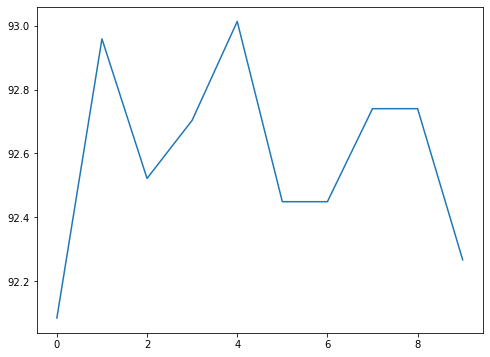

CPU times: user 7.76 s, sys: 1.14 s, total: 8.9 s
Wall time: 7.69 s


In [6]:
%%time
ovr = OvrClassifier()

# Determine mean/std error of accuracies
ovr_accuracies = list()

for i in range(10):
  print(f"Random test run {i}")
  
  X_train_temp, y_train_temp, X_test_temp, y_test_temp = train_test_split(X, y)
  ovr.fit(X=X_train_temp, y_true=y_train_temp)
  
  ovr_y_pred = ovr.predict(X=X_test_temp)  
  ovr_accuracies.append(
      accuracy_score(
          y_pred=ovr_y_pred,
          y_true=y_test_temp, 
        )*100
      )
  
print("One-vs-all accuracy:\nmean {}, std-dev {}".format(
  np.mean(ovr_accuracies),
  np.std(ovr_accuracies)
))

fig = plt.figure(figsize=(8,6))
plt.plot([i for i in range(0,10)], ovr_accuracies)
plt.show()

## Exercise (B) All-Pairs Decomposition

Repeat exercise A with **All-pairs decomposition** instead of one-vs-rest. How do the two techniques compare on this data set?

In [7]:
class AllPairClassifier(BaseEstimator, ClassifierMixin):
  """All Pairs multiclass strategy."""
  def __init__(self):
    pass
  
  def fit(self, X: list, y_true: list) -> object:
    """
    Manual training of all pairs classifier using Logistic Regression as the base learner.

    Parameters
    ----------
    X: list
      Data

    y_true: list
      Multi-class targets.

    Returns
    -------
    self: object
      Instance of fitted estimator.
    """

    # models[i][j] predicts 1 for i, 0 for j
    self.models = np.empty(shape=(10, 10), dtype=LogisticRegression)
    self.models.fill(None)
    for i in range(10):
        for j in range(i):
            X_filtered = [
                obs for (obs, true_class) in zip(X, y_true)
                if true_class in (i, j)
            ]
            y_filtered = [
                1 if true_class == i else 0 for true_class in y_true
                if true_class in (i, j)
            ]
            base_learner = LogisticRegression(
                solver='liblinear'
            )
            self.models[i, j] = base_learner.fit(X_filtered, y_filtered)

    return self

  def predict(self, X: list) -> list:
    """
    Predict the class labels using ovr method from different models trained on different classes.

    Parameters
    ----------
    X: list
      Data

    Returns
    -------
    y_pred: list
      Predicted multi-class targets.
    """
    y_pred = list()
    for x in X:
      votes = [0] * 10
      for k in range(10):
        for i in range(10):
          if i < k:
            prediction = (
                self.models[k, i].predict_proba(
                    [x]
                ).transpose()[1]
            )[0]
          elif i> k:
            prediction = 1 - (
                self.models[i, k].predict_proba(
                    [x]
                ).transpose()[1]
            )[0]
          else:
            continue
          votes[k] += prediction
      y_pred.append(np.argmax(votes))
    return y_pred

Random test run 0
Random test run 1
Random test run 2
Random test run 3
Random test run 4
Random test run 5
Random test run 6
Random test run 7
Random test run 8
Random test run 9
All-pairs accuracy:
mean 97.72379912663756, std-dev 0.22848376815192314


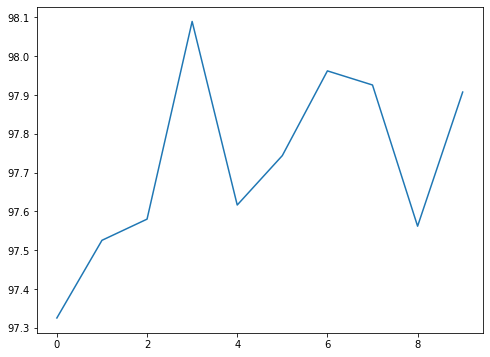

CPU times: user 7min 32s, sys: 34.3 s, total: 8min 6s
Wall time: 7min 30s


In [8]:
%%time
ap = AllPairClassifier()

# Determine mean/std error of accuracies
ap_accuracies = list()

for i in range(10):
  print(f"Random test run {i}")

  X_train_temp, y_train_temp, X_test_temp, y_test_temp = train_test_split(X, y)
  ap.fit(X_train_temp, y_train_temp)

  ap_y_pred = ap.predict(X=X_test_temp)
  ap_accuracies.append(
      accuracy_score(
          y_pred=ap_y_pred,
          y_true=y_test_temp, 
      )*100
  )
print("All-pairs accuracy:\nmean {}, std-dev {}".format(
  np.mean(ap_accuracies),
  np.std(ap_accuracies)
))

fig = plt.figure(figsize=(8,6))
plt.plot([i for i in range(0,10)], ap_accuracies)
plt.show()

## Exercise (C) Confusion Matrix

One would expect that some digits are more difficult to distinguish than others.  Validate (or refute) this expectation by computing the (average) confusion matrix $C=(c_{i,j})_{1 \leq i ,j \leq 10}$, where $c_{i,j}$ is the number of times digit $i$ has been classified as digit $j$ (in the test data). Compare the confusion matrices you obtain for one-vs-rest and all-pairs learning, respectively. Are there any notable differences?


1.0.2


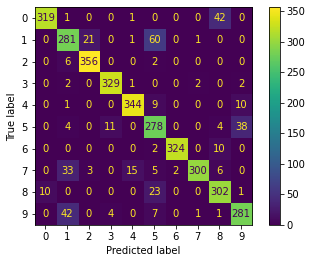

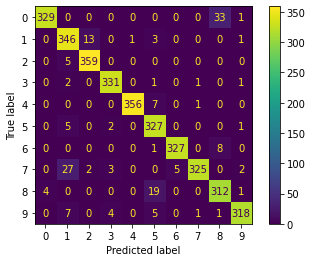

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

for clf_cls in [OvrClassifier, AllPairClassifier]:
    estimator = clf_cls().fit(X_train, y_train)
    ConfusionMatrixDisplay.from_estimator(
        estimator=estimator,
        X=X_test,
        y=y_test
    )
    plt.show()